In [3]:
import tensorflow as tf
import numpy as np

In [22]:
# We'll attempt to simulate the power method.
initial = tf.constant([1, 0, 0], dtype=tf.float32)
num_nodes = initial.shape[0]
edges = tf.constant([[0, 1], [0, 2], [1, 2]], dtype=tf.int64)
edge_weights = tf.ones(edges.shape[0], dtype=tf.float32)
adjacency_matrix = tf.sparse.SparseTensor(
    indices=edges, values=edge_weights, dense_shape=[initial.shape[0], initial.shape[0]]
)
print("Adjacency matrix:\n", tf.sparse.to_dense(adjacency_matrix).numpy())
# Transpose the adjacency matrix to get the correct direction for PageRank
out_degrees = tf.sparse.reduce_sum(adjacency_matrix, axis=1, keepdims=True)  # Column vector of out-degrees
print("Out Degrees:\n", out_degrees.numpy())
transition_matrix = tf.divide(adjacency_matrix, out_degrees)
print("Transition matrix:\n", tf.sparse.to_dense(transition_matrix).numpy())
transition_matrix = tf.sparse.transpose(transition_matrix)
print("Transposed Transition matrix:\n", tf.sparse.to_dense(transition_matrix).numpy())


damping = 0.95
y = tf.expand_dims(initial, axis=1)
norms = [tf.reduce_sum(y)]
for _ in range(1000):
    y = tf.sparse.sparse_dense_matmul(transition_matrix, y) * damping + (1 - damping) / num_nodes
    norms.append(tf.reduce_sum(y))

print("Final PageRank:", tf.squeeze(y, axis=1).numpy())

Adjacency matrix:
 [[0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 0.]]
Out Degrees:
 [[2.]
 [1.]
 [0.]]
Transition matrix:
 [[0.  0.5 0.5]
 [0.  0.  1. ]
 [0.  0.  0. ]]
Transposed Transition matrix:
 [[0.  0.  0. ]
 [0.5 0.  0. ]
 [0.5 1.  0. ]]
Final PageRank: [0.01666667 0.02458333 0.0479375 ]


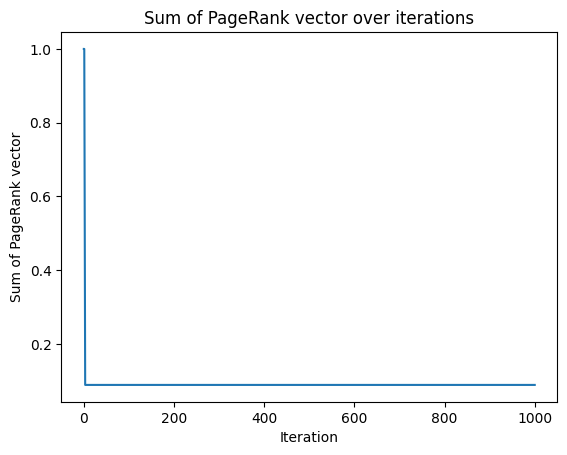

In [21]:
import matplotlib.pyplot as plt

plt.plot(norms)
plt.title("Sum of PageRank vector over iterations")
plt.xlabel("Iteration")
plt.ylabel("Sum of PageRank vector")
plt.show()

We can see that the 1-norm of the vector converges to something lower than 1. This is because the transition matrix is **substochastic**. (Some rows sum to less than 1, corresponding to nodes with no outgoing edges.) To soften this effect, we can introduce a damping factor (also called teleportation) that redistributes some of the weight uniformly across all nodes at each iteration. This ensures that the algorithm will converge to some value. However, when a dead end node is reached in the random surfing model, with probability $\alpha$, we loose the page rank mass (because we should follow a link, but there is none to follow).

A common solution for this is the **Always Teleport from Dead Ends** strategy: When a random surfer lands on a dead end, it will **always teleport** to a random page with equal probability. This can be implemented by modifying the transition matrix prior to the computation so that rows corresponding to dead end nodes are replaced with uniform distributions over all nodes. This way, when a random surfer reaches a dead end, it will have an equal chance of jumping to any other page in the network.

In [ ]:
# We'll attempt to simulate the power method.
initial = tf.constant([1, 0, 0], dtype=tf.float32)
num_nodes = initial.shape[0]
edges = tf.constant([[0, 1], [0, 2], [1, 2]], dtype=tf.int64)
edge_weights = tf.ones(edges.shape[0], dtype=tf.float32)
adjacency_matrix = tf.sparse.SparseTensor(
    indices=edges, values=edge_weights, dense_shape=[initial.shape[0], initial.shape[0]]
)
print("Adjacency matrix:\n", tf.sparse.to_dense(adjacency_matrix).numpy())
# Transpose the adjacency matrix to get the correct direction for PageRank
out_degrees = tf.sparse.reduce_sum(adjacency_matrix, axis=1, keepdims=True)  # Column vector of out-degrees
print("Out Degrees:\n", out_degrees.numpy())
transition_matrix = tf.divide(adjacency_matrix, out_degrees)
print("Transition matrix:\n", tf.sparse.to_dense(transition_matrix).numpy())
# Identify dead ends (nodes with no outgoing edges)
dead_ends = tf.where(tf.equal(out_degrees, 0))[:, 0]
print("Dead Ends:", dead_ends.numpy())
# Replace rows corresponding to dead ends with uniform distributions
for dead_end in dead_ends.numpy():
    indices = tf.constant([[dead_end, i] for i in range(num_nodes)], dtype=tf.int64)
    values = tf.fill([num_nodes], 1.0 / num_nodes)
    dead_end_row = tf.sparse.SparseTensor(indices=indices, values=values, dense_shape=[num_nodes, num_nodes])
    transition_matrix = tf.sparse.add(tf.sparse.reorder(transition_matrix), tf.sparse.reorder(dead_end_row))

print("Transformed Transition matrix:\n", tf.sparse.to_dense(transition_matrix).numpy())
transition_matrix = tf.sparse.transpose(transition_matrix)
print("Transposed Transition matrix:\n", tf.sparse.to_dense(transition_matrix).numpy())


damping = 0.95
y = tf.expand_dims(initial, axis=1)
norms = [tf.reduce_sum(y)]
for _ in range(1000):
    y = tf.sparse.sparse_dense_matmul(transition_matrix, y) * damping + (1 - damping) / num_nodes
    norms.append(tf.reduce_sum(y))

print("Final PageRank:", tf.squeeze(y, axis=1).numpy())

Adjacency matrix:
 [[0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 0.]]
Out Degrees:
 [[2.]
 [1.]
 [0.]]
Transition matrix:
 [[0.  0.5 0.5]
 [0.  0.  1. ]
 [0.  0.  0. ]]
Dead Ends: [2]
Transformed Transition matrix:
 [[0.         0.5        0.5       ]
 [0.         0.         1.        ]
 [0.33333334 0.33333334 0.33333334]]
Transposed Transition matrix:
 [[0.         0.         0.33333334]
 [0.5        0.         0.33333334]
 [0.5        1.         0.33333334]]
Final PageRank: [0.18687221 0.27563652 0.5374912 ]


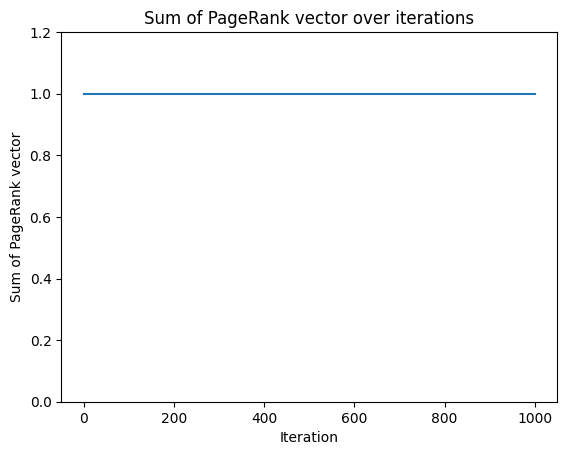

In [43]:
import matplotlib.pyplot as plt

plt.plot(norms)
plt.ylim(0, 1.2)
plt.title("Sum of PageRank vector over iterations")
plt.xlabel("Iteration")
plt.ylabel("Sum of PageRank vector")
plt.show()

We've fixed it